In [16]:
import json, pickle
import numpy as np
from collections import defaultdict
from itertools import groupby
import matplotlib.pyplot as plt
from metric import evaluate, ndcg, average_precision, precision
from utils import WordVector, load_judge_file

## ranking judgment

In [3]:
def rank_judge(json_filename, judgement_filename, file_format='text', reverse=False):
    rel_level = 2
    def relevance_mapper(r):
        if r < 0:
          return 0
        if r >= rel_level:
          return rel_level - 1
        return r
    test_qd_judge = load_judge_file(judgement_filename, file_format=file_format, reverse=reverse)
    for q in test_qd_judge:
        for d in test_qd_judge[q]:
          test_qd_judge[q][d] = relevance_mapper(test_qd_judge[q][d])
    ranks = json.load(open(json_filename, 'r'))
    def dedup(q, docs):
        ndocs = []
        docs_set = set()
        for d in docs:
            if d not in docs_set:
                ndocs.append(d)
                docs_set.add(d)
        return ndocs
    ranks = dict((q, dedup(q, ranks[q])) for q in ranks)
    print('avg #docs per query: {}'.format(np.mean([len(ranks[q]) for q in ranks])))
    for metric, top_k in [('precision', 1), ('precision', 5), ('precision', 10), 
                          ('average_precision', 1), ('average_precision', 5), ('average_precision', 10), ('average_precision', 1000)]:
        scores = evaluate(ranks, test_qd_judge, metric=eval(metric), top_k=top_k)
        avg_score = np.mean(list(scores.values()))
        print('{} {}: {}'.format(metric, top_k, avg_score))

In [4]:
print('matchpyramid')
rank_judge('ranking/matchpyramid/ranking.30.json', 'data/apple_small/test.prep.pointwise', 'text', False)

matchpyramid
avg #docs per query: 366.8448275862069
precision 1: 0.0603448275862069
precision 5: 0.034482758620689655
precision 10: 0.027586206896551727
average_precision 1: 0.0603448275862069
average_precision 5: 0.08994252873563219
average_precision 10: 0.0990353037766831
average_precision 1000: 0.07631416566679959


In [5]:
print('tfidf: use log(tf) || use normalization || use df')
rank_judge('../MatchZoo/experiment/apple_small/ranking/tfidf.json', 'data/apple_small/test.prep.pointwise', 'text', False)

tfidf: use log(tf) || use normalization || use df
avg #docs per query: 366.8448275862069
precision 1: 0.6724137931034483
precision 5: 0.2827586206896551
precision 10: 0.17068965517241383
average_precision 1: 0.6724137931034483
average_precision 5: 0.7228687739463603
average_precision 10: 0.7004436918445539
average_precision 1000: 0.6665067706827957


In [6]:
print('tf: use log(tf) || use normalization')
rank_judge('../MatchZoo/experiment/apple_small/ranking/tf.json', 'data/apple_small/test.prep.pointwise', 'text', False)

tf: use log(tf) || use normalization
avg #docs per query: 366.8448275862069
precision 1: 0.5344827586206896
precision 5: 0.24482758620689657
precision 10: 0.1448275862068966
average_precision 1: 0.5344827586206896
average_precision 5: 0.5933908045977011
average_precision 10: 0.5826855842911877
average_precision 1000: 0.537250900144372


In [7]:
print('tf_nonorm: use log(tf)')
rank_judge('../MatchZoo/experiment/apple_small/ranking/tf_nonorm.json', 'data/apple_small/test.prep.pointwise', 'text', False)

tf_nonorm: use log(tf)
avg #docs per query: 366.8448275862069
precision 1: 0.14655172413793102
precision 5: 0.06724137931034484
precision 10: 0.05689655172413793
average_precision 1: 0.14655172413793102
average_precision 5: 0.18448275862068964
average_precision 10: 0.20461651614668858
average_precision 1000: 0.1755718233759357


In [8]:
print('tf: ')
rank_judge('../MatchZoo/experiment/apple_small/ranking/tf_nonorm_nosublinear.json', 'data/apple_small/test.prep.pointwise', 'text', False)

tf: 
avg #docs per query: 366.8448275862069
precision 1: 0.02586206896551724
precision 5: 0.022413793103448276
precision 10: 0.022413793103448276
average_precision 1: 0.02586206896551724
average_precision 5: 0.04454022988505747
average_precision 10: 0.05430692391899289
average_precision 1000: 0.05942179084335082


In [9]:
print('log tf: ')
rank_judge('ranking/log_tf/ranking.1.json', 'data/apple_small/test.prep.pointwise', 'text', False)

log tf: 
avg #docs per query: 366.8448275862069
precision 1: 0.3103448275862069
precision 5: 0.13103448275862067
precision 10: 0.07672413793103448
average_precision 1: 0.3103448275862069
average_precision 5: 0.34630028735632185
average_precision 10: 0.3433966201423098
average_precision 1000: 0.29068433086339085


## embedding visualization

In [13]:
def emb_vis(filepath):
    wv = WordVector(filepath=filepath, first_line=True)
    length = np.sqrt(np.sum(wv.vectors * wv.vectors, axis=1))
    plt.hist(length, bins=100)
    plt.show()

0.0


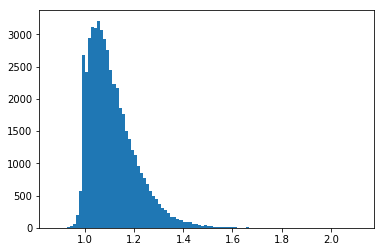

In [14]:
emb_vis('data/bing/w2v_update_all_330_pad_tfrecord')

0.0


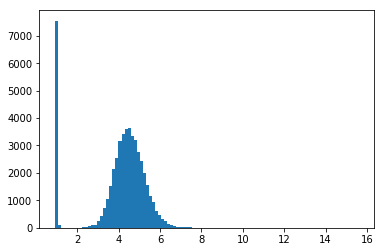

In [15]:
emb_vis('data/bing/w2v')

## density visualization

In [59]:
def density_vis(filepath):
    rel_density, nonrel_density = pickle.load(open(filepath, 'rb'))
    bins = np.linspace(-0.1, 1.5, 100)
    plt.hist(rel_density, bins, alpha=0.5, label='rel', density=True)
    plt.hist(nonrel_density, bins, alpha=0.5, label='nonrel', density=True)
    plt.legend(loc='upper right')
    plt.show()

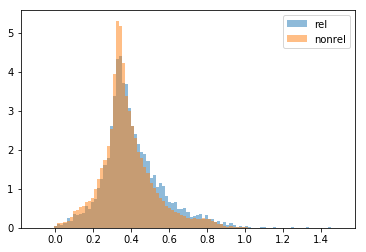

In [48]:
density_vis('density_test.data')

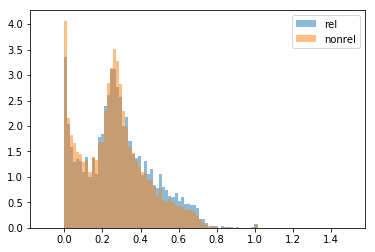

In [49]:
density_vis('density_test_05.data')

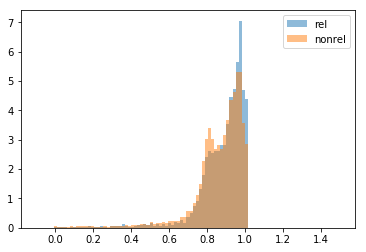

In [50]:
density_vis('density_test_01.data')

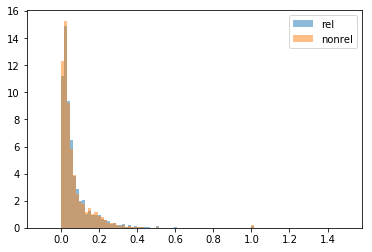

In [51]:
density_vis('density_test_relative_02.data')

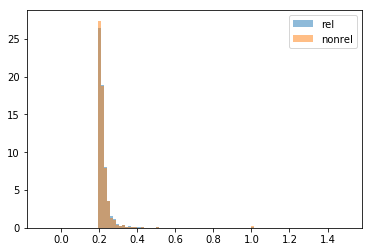

In [63]:
density_vis('density_test_percentile_02.data')

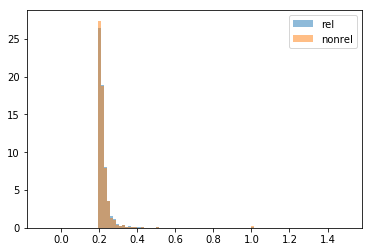

In [67]:
density_vis('density_test_tfpercentile_02.data')

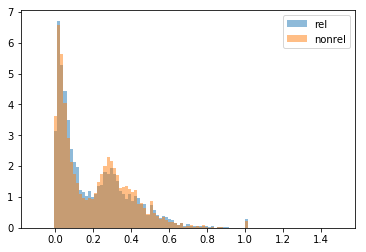

In [52]:
density_vis('density_test_relative_05.data')

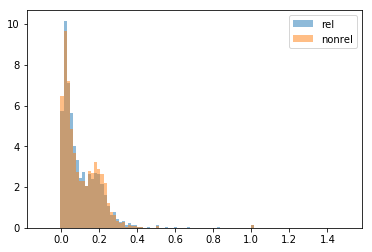

In [64]:
density_vis('density_test_relative_mean_05.data')

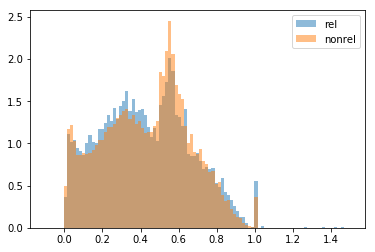

In [54]:
density_vis('density_test_relative_07.data')

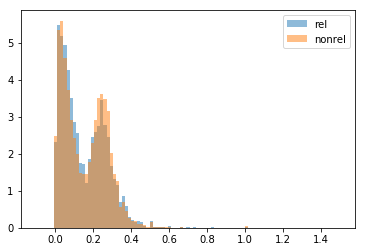

In [65]:
density_vis('density_test_relative_mean_07.data')